In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("../.."))
for item in sys.path:
	print(item)

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code
/home/kian/anaconda3/envs/thesis2/lib/python311.zip
/home/kian/anaconda3/envs/thesis2/lib/python3.11
/home/kian/anaconda3/envs/thesis2/lib/python3.11/lib-dynload

/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import matplotlib.pyplot as plt

from datetime import datetime
import time
import json

import Series_Elastic_Actuator.robot_parameters_SEA as robot_parameters_SEA
import Series_Elastic_Actuator.transforms_SEA as transforms_SEA
import Series_Elastic_Actuator.dynamics_SEA as dynamics_SEA

import Series_Elastic_Actuator.Learning.training_data_SEA as training_data_SEA
import Plotting.theta_visualiser as theta_visualizer

import Series_Elastic_Actuator.Learning.autoencoders_SEA as autoencoders_SEA

from functools import partial

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters_SEA.SEA_PARAMETERS
print(rp)

cuda
{'I0': 2.0, 'I1': 3.0, 'k': 0.3}


In [4]:
points = training_data_SEA.points.to(device)

In [5]:
def points_plotter(points, extend = None, save = False, file_path = None):

   """ 
   Simple plotter function which visualizes the points used for training of the Autoencoder. 
   """
    
   plt.figure(figsize=(6, 6))
   plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
   plt.title('Scatter Plot of q0 vs q1')
   plt.xlabel('q0')
   plt.ylabel('q1')
   plt.xlim(-2*torch.pi, 2*torch.pi)
   plt.ylim(-2*torch.pi, 2*torch.pi)
   plt.grid(True)
   
   if save:
	   plt.savefig(file_path, dpi=800)
   plt.show()

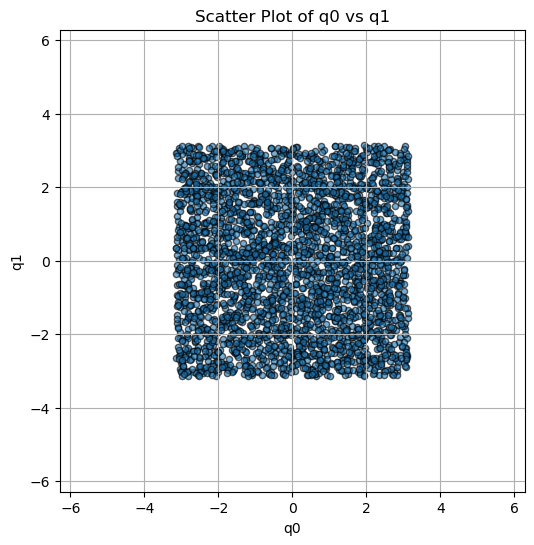

In [6]:
points_plotter(points)

In [7]:
def make_dataset(points):

	"""
	Compute mass- and input matrix of all training points to reduce load in training.
	Returns TensorDataset of (q, M_q, A_q). 
	"""

	data_pairs = []
	for point in points:
		Mq_point, _ = dynamics_SEA.dynamical_matrices(rp, point, point)
		Aq_point = dynamics_SEA.input_matrix()
		data_pairs.append((point, Mq_point, Aq_point))

	points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
	mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
	input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

	# Create TensorDataset
	dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
	return(dataset)


In [8]:
def make_dataloaders(dataset, batch_size = 512, train_part = 0.7):

	"""
	Creates a training and validation dataloader from an input dataset, based on 
	batch size and the ratio train_part. 
	"""

	train_size = int(train_part * len(dataset))
	val_size = len(dataset) - train_size

	# Create TensorDataset for both training and testing sets
	train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

	# Create the DataLoader for both training and testing sets
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
	val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

	return(train_dataloader, val_dataloader)

In [9]:
import torch.nn.functional as F

f_recon        = 10.
f_diag         = 1. #TODO: CHECK OUT THESE LOSS WEIGHTS
f_off_diag     = 1. #TODO: CHECK OUT THESE LOSS WEIGHTS
f_input        = 1.
f_input_jac    = 1.
f_theta        = 1.
f_inertia_eye  = 0. #TODO: CHECK OUT THESE LOSS WEIGHTS


def loss_fun(q, theta, q_hat, M_q, A_q, J_h_enc, J_h_dec):

	"""
	Loss function for training the Autoencoder. Loss terms are the following:
	l_recon:    Loss between input- and reconstructed variable. (MSE)
	l_off_dia:  Loss of off-diagonal terms of mass matrix in theta-space. (MSE)
	l_dia:      Loss on diagonal terms of mass matrix in theta-space. 
				(mean of normalized negative log-loss)
	l_input:    Loss to drive input matrix in theta-space to [1, 0]^T (MSE)

	"""

	l_recon = F.mse_loss(q, q_hat, reduction="mean")

	# Calculate forward and inverse Jacobians
	J_h = J_h_enc
	J_h_trans = torch.transpose(J_h, 1, 2)
	J_h_inv = J_h_dec
	J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

	M_th = J_h_inv_trans @ M_q @ J_h_inv
	A_th = J_h_inv_trans @ A_q

	# Loss inspired by Pietro Pustina's paper on input decoupling:
	# https://arxiv.org/pdf/2306.07258
	l_input_jac = F.mse_loss(J_h[:, 0, :], A_q[:, :, 0], reduction="mean")



	# Loss on the first coordinate theta, again from Pietro Pustina's analytic formulation
	theta_ana = torch.vmap(transforms_SEA.analytic_theta, in_dims = (None, 0))(rp, q)
	l_theta = F.mse_loss(theta[:, 0], theta_ana[:, 0], reduction="mean")

	# Enforce inertial decoupling
	l_off_diag = torch.mean((M_th[:, 0, 1])**2)
	diag_values = torch.diagonal(M_th, dim1=1, dim2=2)
	l_diag = torch.mean((-1 + torch.exp(-(diag_values - 1))) * (diag_values < 1).float())  # Shape: (batch_size, 2)

	## input decoupling loss
	#l_input = torch.mean((A_th[:, 1]**2)) + torch.mean(((A_th[:, 0]-1)**2))
	l_input = torch.mean((A_th[:, 1]**2))
	
	#print(torch.eye(M_th.size(-1)))]).
	#M_eye = torch.eye(M_th.size(-1), device=M_th.device, dtype=M_th.dtype).expand(M_th.size())
	#l_inertia_eye = F.mse_loss(M_th, M_eye, reduction="mean")
	
	loss_terms = torch.tensor([l_recon * f_recon, l_diag * f_diag, l_off_diag * f_off_diag, 
	                           l_input * f_input, l_input_jac * f_input_jac, l_theta * f_theta])
	loss_sum = l_recon * f_recon + l_diag * f_diag + l_off_diag * f_off_diag + l_input * f_input + l_input_jac * f_input_jac + l_theta * f_theta

	#loss_terms = torch.tensor([l_recon * f_recon, l_inertia_eye * f_inertia_eye, 
	#						   l_input * f_input, l_input_jac * f_input_jac, l_theta * f_theta])
	#loss_sum = l_recon * f_recon + l_inertia_eye * f_inertia_eye + l_input * f_input + l_input_jac * f_input_jac + l_theta * f_theta

	return loss_sum, loss_terms

In [10]:

#model.load_state_dict(torch.load(load_path, weights_only=True))


def train_AE_model(rp, device, lr, num_epochs, q0_split, train_dataloader, val_dataloader, current_time, dir_name = None):

	"""
	Executes training loop for Autoencoder
	"""
	if dir_name is None:
		model = autoencoders_SEA.Autoencoder_double(rp).to(device)  # Move model to GPU
		dir_name = f"NN_{current_time}"
		file_counter = 0
	else:
		dir_path = os.path.join(os.getcwd(), "Models", dir_name)
		nn_filename = dir_name + "_0.pth"
		nn_filepath = os.path.join(dir_path, nn_filename)
		file_counter = 0
		while os.path.isfile(nn_filepath):
			print("Looking for latest weights and bias file.")
			file_counter += 1
			nn_filename = nn_filename[:-6] + "_" + str(file_counter) + ".pth"
			nn_filepath = os.path.join(dir_path, nn_filename)

		model_path = os.path.join("Models", dir_name, dir_name + "_" + str(file_counter-1) + ".pth")
		model = autoencoders_SEA.Autoencoder_double(rp).to(device)  # Initialize model architecture
		model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))  # Load weights

	optimizer = torch.optim.Adam(model.parameters(), lr=lr)#,  weight_decay=1e-6)
	scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))


	train_losses = []
	val_losses = []
	start_time = time.time()       
	dir_path = os.path.join(os.getcwd(), "Models", dir_name)
	os.makedirs(dir_path, exist_ok=True)
	nn_filename = dir_name + "_" + str(file_counter) + ".pth"
	nn_filepath = os.path.join(dir_path, nn_filename)

	metadata = {"q0_low" : q0_split[0],
				"q0_high" : q0_split[1],
				"lr" : lr,
				"epochs" : num_epochs,
				"file_name" : nn_filename,
				"loss_weights": {
					"f_recon": f_recon,
					"f_diag": f_diag,
					"f_off_diag": f_off_diag,
					"f_input": f_input,
					"f_input_jac": f_input_jac,
					"f_theta": f_theta,
					"f_inertia_eye": f_inertia_eye
				}}
	
	metadata_filename = "metadata_" + str(file_counter) + ".json"
	metadata_filepath = os.path.join(dir_path, metadata_filename)
	with open(metadata_filepath, "w") as f:
		json.dump(metadata, f, indent=4)

	for epoch in range(num_epochs):

		# Training phase
		model.train()
		train_loss = 0
		train_loss_terms = torch.zeros(6)
		for index, (q, M_q, A_q) in enumerate(train_dataloader):
			q = q.to(device)
			M_q = M_q.to(device)
			A_q = A_q.to(device)

			batch_size = q.size(0)
			
			theta, J_h, q_hat, J_h_dec, J_h_ana = model.forward(q)  
			theta_ana = model.theta_ana(q)
					
			loss, loss_terms = loss_fun(q, theta, q_hat, M_q, A_q, J_h, J_h_dec)
			
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			
			train_loss += loss.item() * batch_size
			train_loss_terms += loss_terms * batch_size
		train_loss /= len(train_dataloader.dataset) 
		train_loss_terms /= len(train_dataloader.dataset) 
		train_losses.append(train_loss)

		# Validation phase
		model.eval()
		val_loss = 0
		val_loss_terms = torch.zeros(6)
		with torch.no_grad():
			for index, (q, M_q, A_q) in enumerate(val_dataloader):
				q = q.to(device)
				M_q = M_q.to(device)
				A_q = A_q.to(device)

				batch_size = q.size(0)

				theta, J_h, q_hat, J_h_dec, J_h_ana = model.forward(q)
				theta_ana = model.theta_ana(q)

				loss, loss_terms = loss_fun(q, theta, q_hat, M_q, A_q, J_h, J_h_dec)

				val_loss += loss.item() * batch_size
				val_loss_terms += loss_terms * batch_size
		val_loss /= len(val_dataloader.dataset)
		val_loss_terms /= len(val_dataloader.dataset)
		val_losses.append(val_loss)
		epoch_duration = time.time() - start_time
		scheduler.step()
		tlt = train_loss_terms
		print(
			f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds')
		print(
		    f'l_recon: {tlt[0]:.4f}, l_diag: {tlt[1]:.4f}, l_off_diag: {tlt[2]:.4f}, l_input: {tlt[3]:.4f}, l_input_jac: {tlt[4]:.4f}, l_theta: {tlt[5]:.4f}')
		#print(
		#	f'l_recon: {tlt[0]:.4f}, l_inertia: {tlt[1]:.4f}, l_input: {tlt[2]:.4f}, l_input_jac: {tlt[3]:.4f}, l_theta: {tlt[4]:.4f}')
		
	return(model, train_losses, val_losses, dir_path, nn_filepath, file_counter)


In [11]:
def save_model(model, file_path):
	torch.save(model.state_dict(), file_path)
	print(f"Model parameters saved to {file_path}")


In [12]:
def plot_loss(train_losses, val_losses, log = False, save = False, file_path = None):

	"""
	Plots training and validation loss. 
	ylim" and "yscale" should be enabled depending on the loss function.
	"""

	plt.figure(figsize=(10, 6))
	plt.plot(train_losses, label="Training Loss")
	plt.plot(val_losses, label="Validation Loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	#plt.ylim((-1, 40))
	plt.legend()
	plt.title("Training and Validation Loss over Epochs")
	plt.grid(True)
	if log:
		plt.yscale("log")
	if save:
		plt.savefig(file_path, dpi=800)
	plt.show()


In [13]:
import Plotting.plotters_simple as plotters_simple

def make_plot_dataloader(dataset):

	"""
	Takes the training dataset and returns a dataloader of every 10th point
	to reduce visual clutter. 
	"""

	points_tensor, mass_matrices_tensor, input_matrices_tensor = dataset.tensors
	
	plot_sampled = points_tensor[::10]
	mass_sampled = mass_matrices_tensor[::10]
	input_sampled = input_matrices_tensor[::10]

	plot_dataset = TensorDataset(plot_sampled, mass_sampled, input_sampled)
	plot_dataloader = DataLoader(plot_dataset, batch_size=len(plot_dataset), shuffle=False, num_workers=0)

	return(plot_dataloader)

In [14]:
def plot_model_performance(model, plot_dataloader, folder_path):

	model_ana = autoencoders_SEA.Analytic_transformer(rp)

	os.makedirs(folder_path, exist_ok=True)

	model.eval()
	with torch.no_grad():
		for (q, M_q, A_q) in plot_dataloader:
			q = q.to(device)
			M_q = M_q.to(device)
			A_q = A_q.to(device)

			theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
			theta_ana = model.theta_ana(q)
			J_h_trans = torch.transpose(J_h, 1, 2)
			J_h_inv = J_h_dec
			J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

			J_h_inv_ana = torch.linalg.inv(J_h_ana)
			J_h_inv_trans_ana = torch.transpose(J_h_inv_ana, 1, 2)

			M_th = J_h_inv_trans @ M_q @ J_h_inv
			A_th = (J_h_inv_trans @ A_q).squeeze(-1)

			M_th_ana = J_h_inv_trans_ana @ M_q @ J_h_inv_ana
			A_th_ana = (J_h_inv_trans_ana @ A_q).squeeze(-1)

			
			plotters_simple.plot_3d_quad(q, [theta_ana[:, 0], theta[:, 0], theta_ana[:, 1], theta[:, 1]], "Analytic vs learned theta", 
										 ["th0_ana", "th0_learned", "th_1_ana", "th_1_learned"], "q_0", "q_1", "th", folder_path)
			


			plotters_simple.plot_3d_double(q, [A_th[:, 0], A_th[:, 1]], "Input decoupling", ["A0", "A1"], "q_0", "q_1", "A", folder_path)
			
			A_th = A_th.cpu().detach().numpy()
			print("Percentage of abs(A_0) > 0.6:", 100 * np.sum(np.abs(A_th[:, 0]) > 0.6)/A_th[:, 0].size, "%")
			print("Percentage of abs(A_1) < 0.3:", 100 * np.sum(np.abs(A_th[:, 1]) < 0.3)/A_th[:, 1].size, "%")
			
			plotters_simple.plot_3d_quad(q, [M_th[:, 0, 0], M_th[:, 0, 1], M_th[:, 1, 0], M_th[:, 1, 1]], "M_th vs q", 
										 ["M_th[0,0]", "M_th[0,1]", "M_th[1,0]", "M_th[1,1]"], "q_0", "q_1", "M_th", folder_path)
			M_th_cpu = M_th.cpu().detach().numpy()
			print("Percentage of abs(M_00) > 1.0:", 100 * np.sum(np.abs(M_th_cpu[:, 0, 0]) > 1.0)/M_th_cpu[:, 0, 0].size, "%")
			print("Percentage of abs(M_01) < 0.2:", 100 * np.sum(np.abs(M_th_cpu[:, 0, 1]) < 0.2)/M_th_cpu[:, 0, 1].size, "%")
			print("Percentage of abs(M_11) > 1.0:", 100 * np.sum(np.abs(M_th_cpu[:, 1, 1]) > 1.0)/M_th_cpu[:, 1, 1].size, "%")

			plotters_simple.plot_3d_quad(theta, [M_th[:, 0, 0], M_th[:, 0, 1], M_th[:, 1, 0], M_th[:, 1, 1]], "M_th vs th", 
										 ["M_th[0,0]", "M_th[0,1]", "M_th[1,0]", "M_th[1,1]"], "th_0", "th_1", "M_th", folder_path)

			plotters_simple.plot_3d_quad(theta, [M_th_ana[:, 0, 0], M_th_ana[:, 0, 1], M_th_ana[:, 1, 0], M_th_ana[:, 1, 1]], "M_th_ana vs th", 
										 ["M_th_ana[0,0]", "M_th_ana[0,1]", "M_th_ana[1,0]", "M_th_ana[1,1]"], "th_0", "th_1", "M_th_ana", folder_path)


			#plotters_simple.plot_3d_double(q, J_h_ana[:, 0, 0], J_h[:, 0, 1], "J_h", "00", "01", "q_0", "q_1", "J_h", device)
			#plotters_simple.plot_3d_double(q, J_h_ana[:, 1, 0], J_h[:, 1, 1], "J_h", "10", "11", "q_0", "q_1", "J_h", device)
		

In [20]:
q1_split = (-torch.pi, torch.pi)
batch_size = 512
train_part = 0.7

num_epochs = 1001
lr = 1e-3

# IMPORTANT:
# If you want to train on an existing model
existing_model_name = "NN_202503231956"
existing_model_name = None

plt.ion()

current_time = datetime.now().strftime("%Y%m%d%H%M")

dataset = make_dataset(points)
(train_dataloader, val_dataloader) = make_dataloaders(dataset=dataset, batch_size=batch_size, train_part=train_part)
outputs = []
model, train_losses, val_losses, dir_path, nn_filepath, file_counter = train_AE_model(rp, device, lr, num_epochs, q1_split, train_dataloader, 
														val_dataloader, current_time, existing_model_name)

Epoch [1/1001], Training Loss: 38.4516, Validation Loss: 37.3545, Duration: 0.08 seconds
l_recon: 33.4236, l_diag: 1.6265, l_off_diag: 0.0000, l_input: 0.0012, l_input_jac: 0.3942, l_theta: 3.0061
Epoch [2/1001], Training Loss: 38.3078, Validation Loss: 37.2304, Duration: 0.16 seconds
l_recon: 33.3238, l_diag: 1.6268, l_off_diag: 0.0000, l_input: 0.0012, l_input_jac: 0.3913, l_theta: 2.9647
Epoch [3/1001], Training Loss: 38.1691, Validation Loss: 37.1144, Duration: 0.24 seconds
l_recon: 33.2278, l_diag: 1.6272, l_off_diag: 0.0000, l_input: 0.0011, l_input_jac: 0.3883, l_theta: 2.9247
Epoch [4/1001], Training Loss: 38.0430, Validation Loss: 37.0074, Duration: 0.32 seconds
l_recon: 33.1451, l_diag: 1.6272, l_off_diag: 0.0000, l_input: 0.0011, l_input_jac: 0.3853, l_theta: 2.8842
Epoch [5/1001], Training Loss: 37.9244, Validation Loss: 36.9043, Duration: 0.40 seconds
l_recon: 33.0685, l_diag: 1.6269, l_off_diag: 0.0000, l_input: 0.0011, l_input_jac: 0.3823, l_theta: 2.8455
Epoch [6/1001],

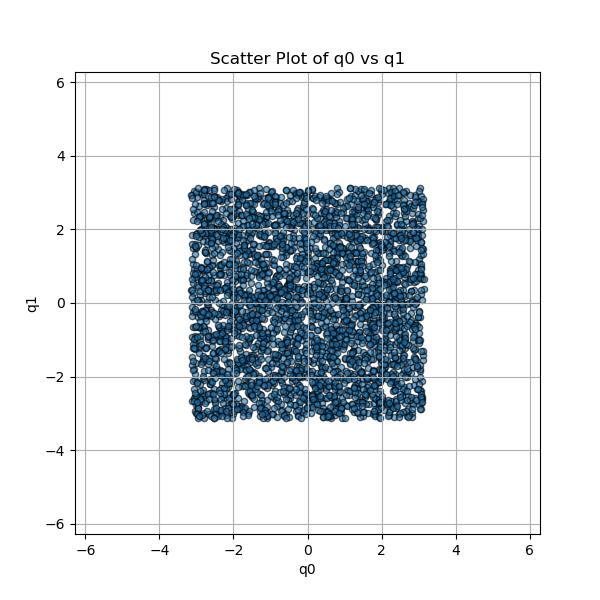

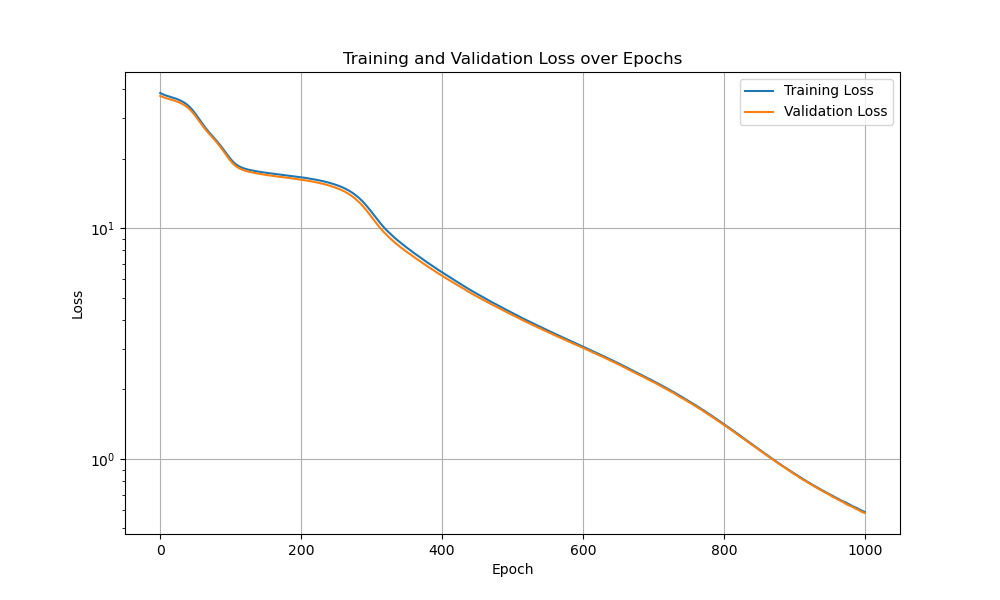

Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Series_Elastic_Actuator/Learning/Models/NN_202504281736/NN_202504281736_0.pth
/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Series_Elastic_Actuator/Learning/Models/NN_202504281736/NN_202504281736_0.pth


In [21]:
points_path = os.path.join(dir_path, "training_points_" + str(file_counter) + ".png")
points_plotter(points, save = True, file_path = points_path)
scatter_fig_path = os.path.join(dir_path, "loss_" + str(file_counter) + ".png")
plot_loss(train_losses, val_losses, log = True, save = True, file_path = scatter_fig_path)
save_model(model, nn_filepath)
print(nn_filepath)

q: torch.Size([2500, 2])
theta: torch.Size([2500, 2])


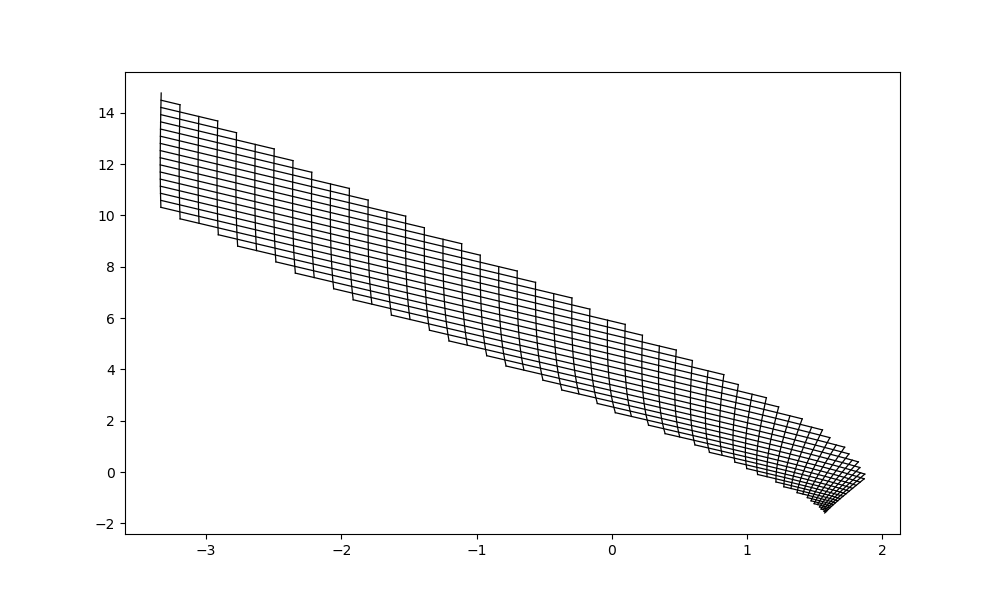

In [22]:
def theta_1_single(model, q):
	print("q:", q.size())
	theta = model.encoder(q)
	print("theta:", theta.size())
	return theta[:, 0].detach()
	
def theta_2_single(model, q):
	theta = model.encoder(q)
	return theta[:, 1].detach()
	
def q_hat_1_single(model, theta):
	q_hat = model.decoder(theta)
	return q_hat[:, 0].detach()
	
def q_hat_2_single(model, theta):
	q_hat = model.decoder(theta)
	return q_hat[:, 1].detach()

mapping_functions = (partial(theta_1_single,model), 
						partial(theta_2_single,model), 
						partial(q_hat_1_single,model), 
						partial(q_hat_2_single,model))
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, device=device, 
											mapping_functions=mapping_functions, mask_split=q1_split)
theta_figure_path = os.path.join(dir_path, "theta_mapping_" + str(file_counter) + ".png")
th_plotter.make_figure(theta_figure_path)
theta_anim_path = os.path.join(dir_path, "theta_mapping_" + str(file_counter) + ".mp4")
#th_plotter.make_animation(theta_anim_path, duration = 4, fps = 20)

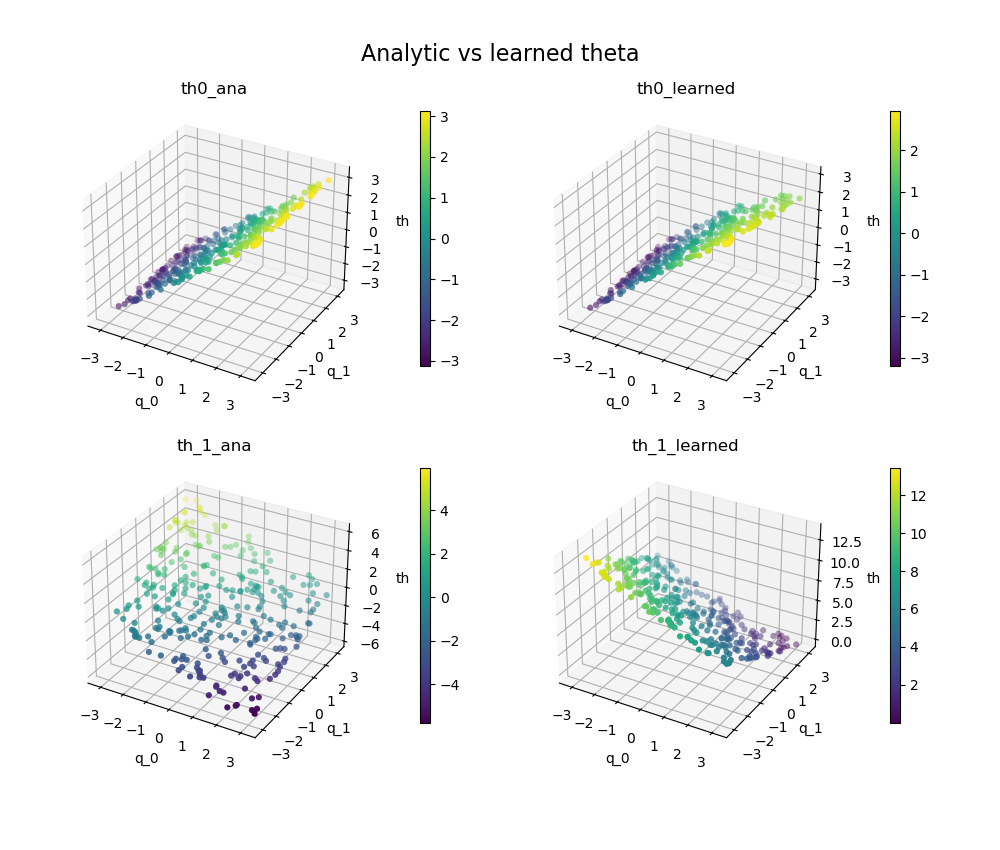

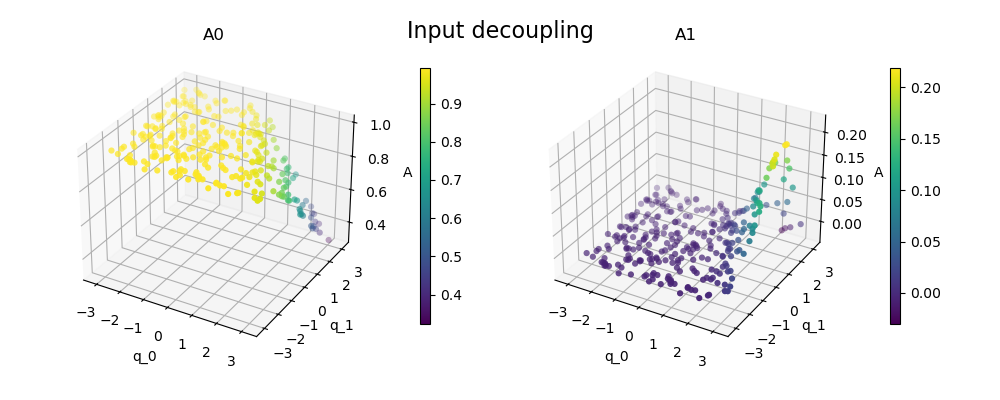

Percentage of abs(A_0) > 0.6: 95.66666666666667 %
Percentage of abs(A_1) < 0.3: 100.0 %


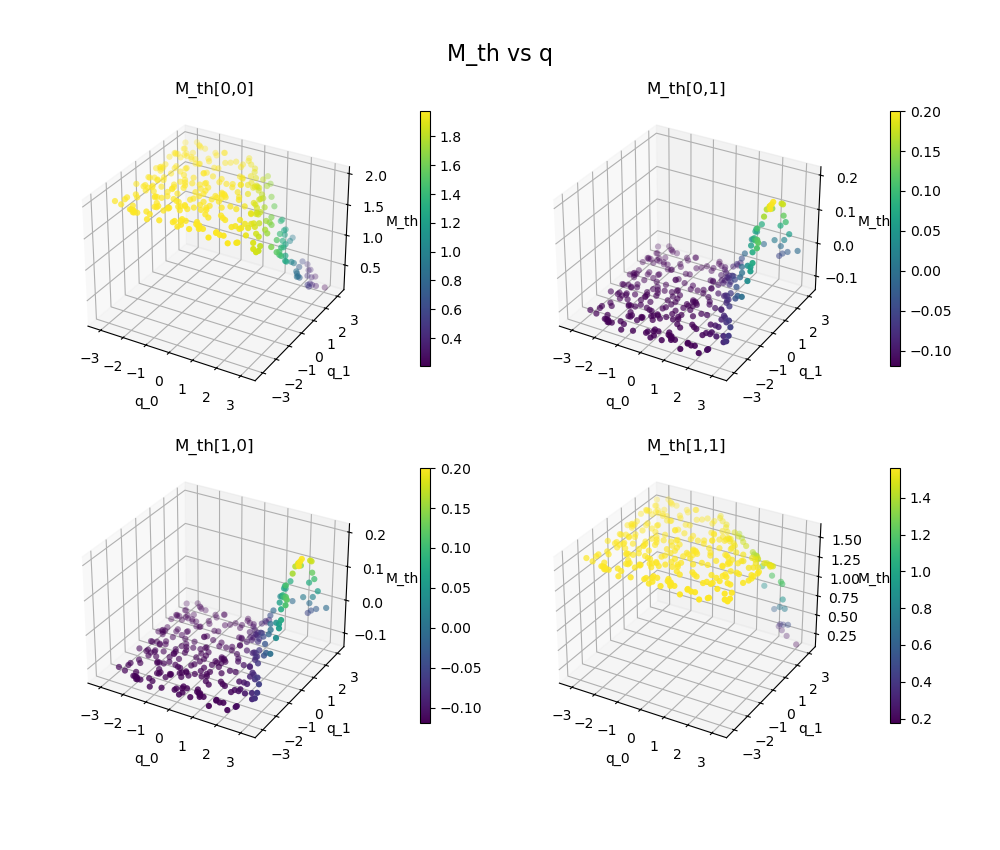

Percentage of abs(M_00) > 1.0: 93.0 %
Percentage of abs(M_01) < 0.2: 99.66666666666667 %
Percentage of abs(M_11) > 1.0: 96.0 %


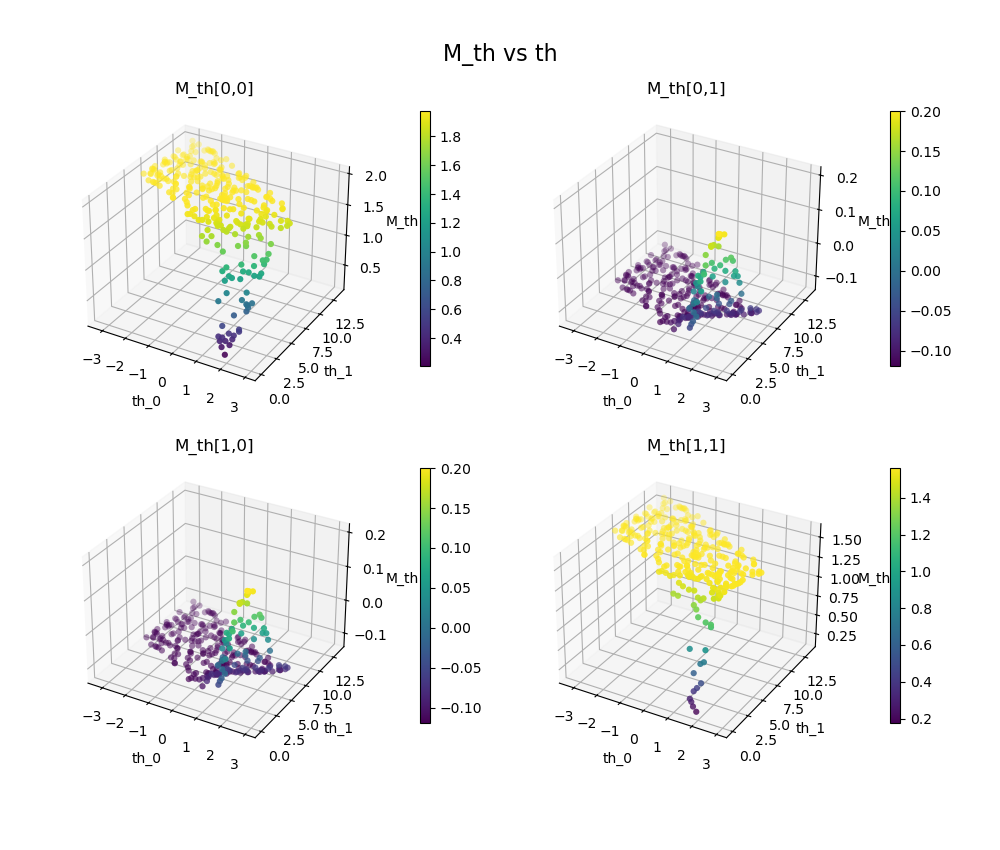

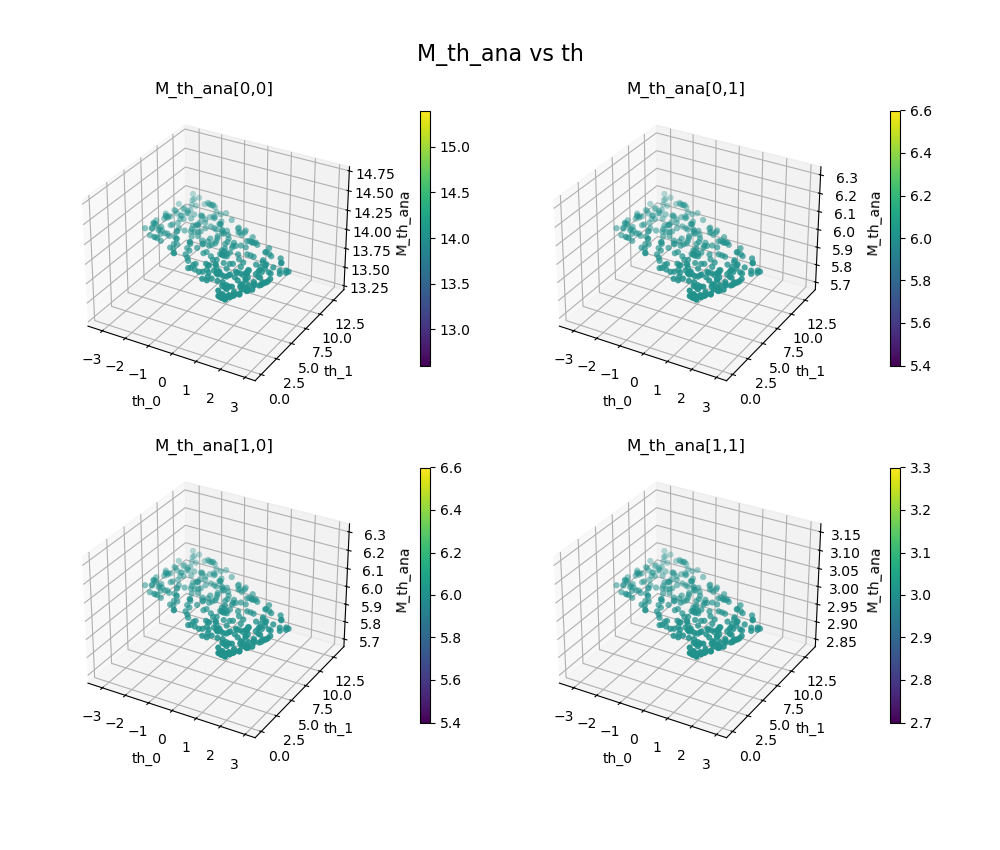

In [23]:
%matplotlib widget

folder_path = os.path.join(dir_path, "performance_plots_" + str(file_counter))

q1_split = (-torch.pi, torch.pi)
plt.ion()
#model = autoencoders.Autoencoder_double(rp).to(device)
#model_location = 'Models/Split_AEs/Lumped_Mass_202503051257.pth'
#model.load_state_dict(torch.load(model_location, weights_only=True))
plot_points = points
plot_dataset = make_dataset(plot_points)
plot_dataloader = make_plot_dataloader(plot_dataset)
plot_model_performance(model, plot_dataloader, folder_path)


KeyError: 'l0'

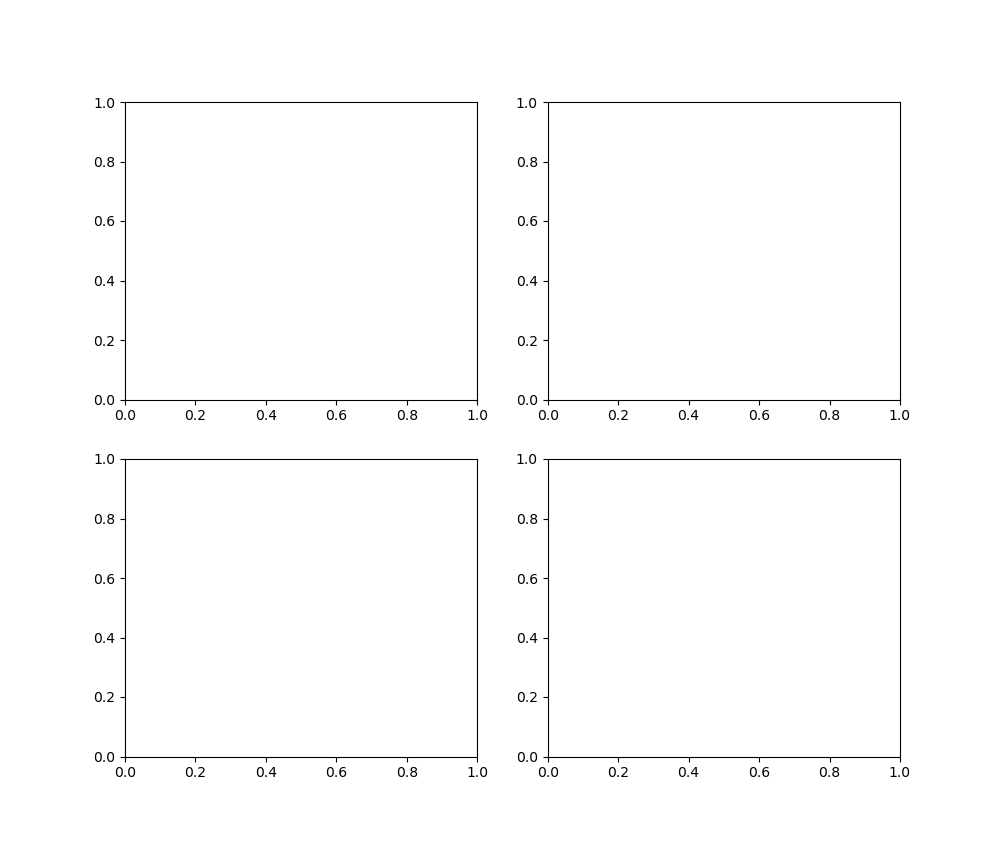

In [19]:
import warnings
warnings.filterwarnings("ignore")

model_ana = autoencoders_SEA.Analytic_transformer(rp)


models = [model_ana, model_ana]
model_names = ["Analytic", "Neural Network"]
dir_path = os.path.join(os.getcwd(), "Models", "Temp_delete_this")
file_counter = 0
theta_xy_fig_path = os.path.join(dir_path, "theta_vs_q" + str(file_counter) + ".png")

def check_clockwise_vectorized(q):
		"""
		Expects q to be a tensor of shape (N,2) where each row is [q1, q2].
		Returns two boolean masks: (cw_mask, ccw_mask), where:
			- cw_mask[i] is True if the i-th configuration is elbow clockwise.
			- ccw_mask[i] is True if the i-th configuration is elbow counterclockwise.
		
		The logic is as follows (from your original function):
			If q1 lies between q0 and q0+π, or between q0-2π and q0-π, then the configuration
			is considered counterclockwise. Otherwise it is clockwise.
		"""
		q0 = q[:, 0]
		q1 = q[:, 1]
		cond_ccw = ((q1 >= q0) & (q1 <= q0 + torch.pi))
		cw_mask = ~cond_ccw
		ccw_mask = cond_ccw
		return cw_mask, ccw_mask


# Define the number of grid points along each dimension.
n_points = 200

# Create 1D tensors for q0 and q1 in the range [-pi, 0]
q0_vals = torch.linspace(-np.pi, np.pi, n_points)
q1_vals = torch.linspace(-np.pi, 2*np.pi, n_points)

# Create a 2D grid (meshgrid) of q values.
# (Note: using indexing='ij' so that the first axis corresponds to q0 and the second to q1)
q0_grid, q1_grid = torch.meshgrid(q0_vals, q1_vals, indexing='ij')

# Stack the grid to get a tensor of shape (n_points*n_points, 2)
q_grid = torch.stack([q0_grid.flatten(), q1_grid.flatten()], dim=1).to(device)

# === Compute theta1 and theta2 using the analytic encoder functions ===
# We use torch.vmap to evaluate the functions over the batch of q values.
# Note: encoder_theta_0_ana and encoder_theta_1_ana each return a tuple (theta, theta).


fig, axes = plt.subplots(2, 2, figsize=(10, 8.5))
for i, (model, model_name) in enumerate(zip(models, model_names)):

		theta_out = model.encoder_vmap(q_grid)
		#theta_out = torch.vmap(model.encoder)(q_grid)

		theta0 = theta_out[:, 0]
		theta1 = theta_out[:, 1]

		# Since q0_grid and q1_grid are already on a mesh, we can compute x_end and y_end elementwise.
		x_end = rp["l0"] * torch.cos(q_grid[:, 0]) + rp["l1"] * torch.cos(q_grid[:, 1])
		y_end = rp["l0"] * torch.sin(q_grid[:, 0]) + rp["l1"] * torch.sin(q_grid[:, 1])

		# --- Determine configuration (clockwise vs. counterclockwise) for each q ---
		cw_mask, ccw_mask = check_clockwise_vectorized(q_grid)
		# Counterclockwise points
		x_end_ccw   = x_end[ccw_mask].detach().cpu().numpy()
		y_end_ccw   = y_end[ccw_mask].detach().cpu().numpy()
		theta0_ccw  = theta0[ccw_mask].detach().cpu().numpy()
		theta1_ccw  = theta1[ccw_mask].detach().cpu().numpy()
		thetas = [theta0_ccw, theta1_ccw]


		for j in range(2):
				sc = axes[i, j].scatter(x_end_ccw, y_end_ccw, c=thetas[j], cmap='viridis', s=5)
				axes[i, j].set_title("th_" + str(j) + " - " + model_names[i])
				axes[i, j].set_xlabel("x")
				axes[i, j].set_ylabel("y")
				plt.colorbar(sc, ax=axes[i, j])


		#sc4 = axes[1].scatter(x_end_ccw, y_end_ccw, c=theta2_ccw, cmap='viridis', s=5)
		#axes[1].set_title("Theta1 - Counterclockwise")
		#axes[1].set_xlabel("x")
		#axes[1].set_ylabel("y")
		#plt.colorbar(sc4, ax=axes[1])

plt.tight_layout()
plt.savefig(theta_xy_fig_path)
plt.show()
